<a href="https://colab.research.google.com/github/rrl7012005/Scikit-Learn-ClassicalML-Course/blob/main/Decision_Trees_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decision Trees

Use the same dataset as last book.

QUESTION: The Rain in Australia dataset contains about 10 years of daily weather observations from numerous Australian weather stations. Here's a small sample from the dataset:

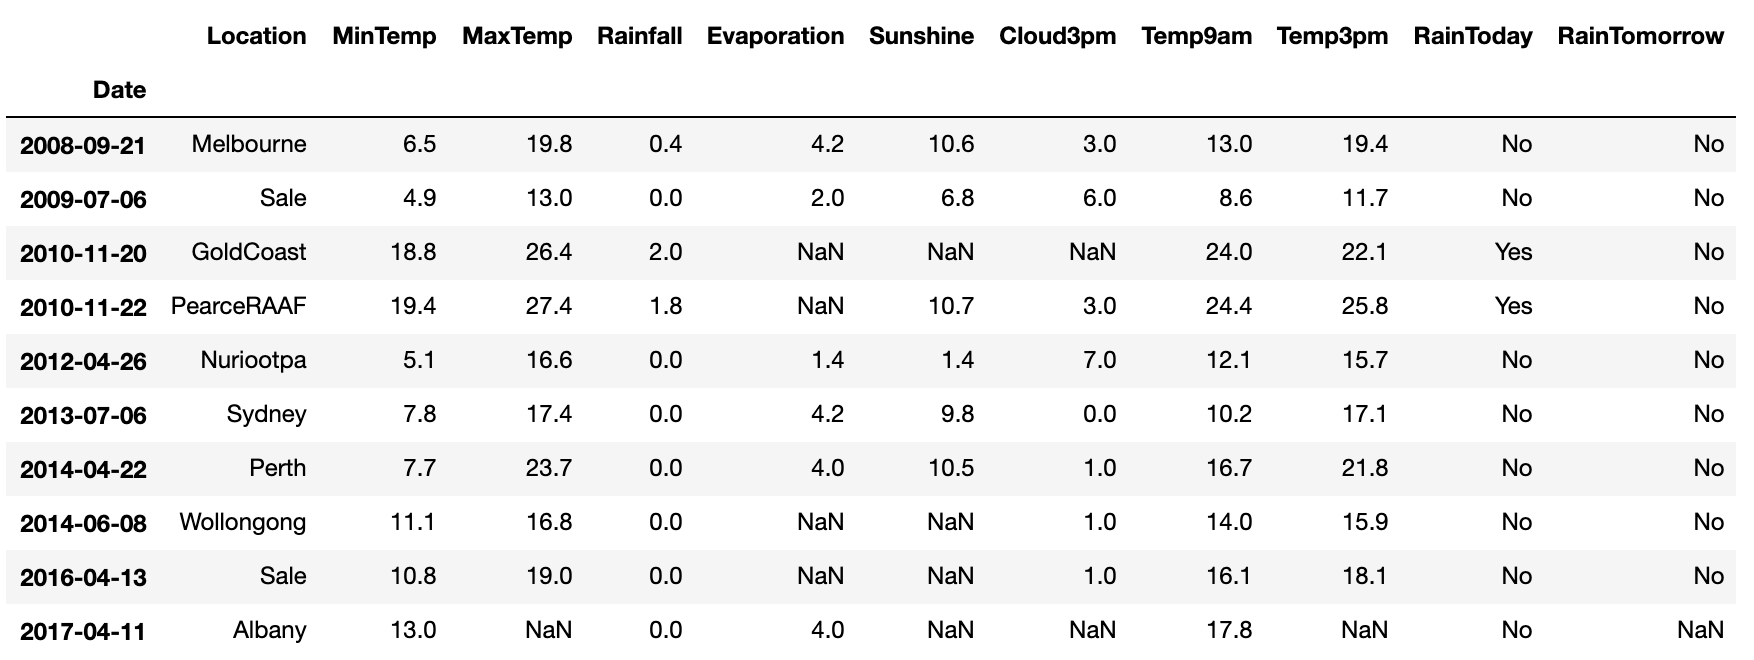

As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow.

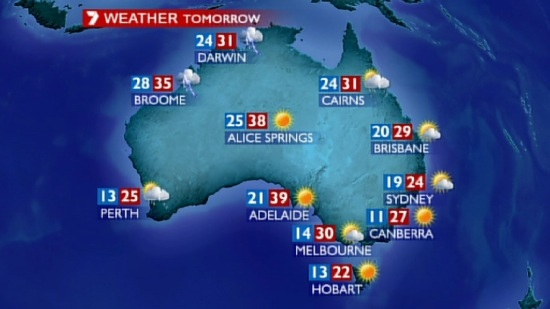https://i.imgur.com/KWfcpcO.png

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [ ]:
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')

Dataset URL: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package


100%|██████████| 3.83M/3.83M [00:00<00:00, 124MB/s]

In [ ]:
os.listdir('weather-dataset-rattle-package')

['weatherAUS.csv']

##Preprocessing

Same preprocessing and imputation and splitting.

In [ ]:
raw_df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

print(numeric_cols)
print(categorical_cols)

train_df.shape : (98988, 23)
val_df.shape : (17231, 23)
test_df.shape : (25974, 23)
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])

train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

scaler = MinMaxScaler().fit(raw_df[numeric_cols])

train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])


test_inputs[numeric_cols].isna().sum(), val_inputs.describe().loc[['min', 'max']] #only describe minimum and maximum

(MinTemp          0
 MaxTemp          0
 Rainfall         0
 Evaporation      0
 Sunshine         0
 WindGustSpeed    0
 WindSpeed9am     0
 WindSpeed3pm     0
 Humidity9am      0
 Humidity3pm      0
 Pressure9am      0
 Pressure3pm      0
 Cloud9am         0
 Cloud3pm         0
 Temp9am          0
 Temp3pm          0
 dtype: int64,
       MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
 min  0.007075  0.030246  0.000000     0.000000       0.0       0.007752   
 max  0.952830  0.948960  0.666307     0.485517       1.0       1.000000   
 
      WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
 min      0.000000      0.000000         0.04          0.0     0.125620   
 max      0.669231      0.850575         1.00          1.0     0.971901   
 
      Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  
 min       0.0816  0.000000  0.000000  0.021097  0.026871  
 max       0.9632  0.888889  0.888889  0.943038  0.925144  )

In [ ]:
train_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.0,0.013233,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0304,0.0,0.0,0.027426,0.005758
max,1.0,1.000000,1.0,0.568276,0.986207,1.0,0.669231,1.0,1.0,1.0,1.0,1.0000,1.0,1.0,1.000000,0.988484


One Hot Encoding

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])

encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

print(encoded_cols) #nans are a separate category

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-8-7936af89997e>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
<ipython-input-8-7936af89997e>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

##Training Decision Trees

Decision Trees represents a hierarchical series of binary decisions where traversing the tree involves answering a set of questions that leads you to the correct class. It is non-linear and a computer comes up with the criteria manually and determines the optimal structure. It can highly adapt and fit to the data hence can be prone to overfitting as it can easily fit to the noise of the data.

In [ ]:
from sklearn.tree import DecisionTreeClassifier #theres a regression tree as well

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

##Performance Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

train_acc = accuracy_score(train_targets, train_preds)
val_acc = accuracy_score(val_targets, val_preds)
test_acc = accuracy_score(test_targets, test_preds)

train_probs = model.predict_proba(X_train)
val_probs = model.predict_proba(X_val)
test_probs = model.predict_proba(X_test) #Decision tree gives probabilities 0 and 1

print('train_acc :', train_acc)
print('val_acc :', val_acc)
print('test_acc: ', test_acc)

print('Train probs:', train_probs)
print('Validation probs:', val_probs)
print('Test probs:', test_probs)

train_acc : 0.9999797955307714
val_acc : 0.7921188555510418
test_acc:  0.7741202741202741
Train probs: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Validation probs: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Test probs: [[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


As can see poor-ish generalization. You can make predictions and compute accuracy in one step instead doing model.predict just run model.score. Also look below and you see that our model is only marginally better and sometimes worse than always predicting no.

In [ ]:
model.score(X_val, val_targets), val_targets.value_counts() / len(val_targets) #Gives the proportion of 1s in y_val

(0.7921188555510418,
 RainTomorrow
 No     0.788289
 Yes    0.211711
 Name: count, dtype: float64)

**Tree Visualization**

We can visualize the created decision tree. The initial node is called the root node and the last node for each branch is called a leaf. Setting max_depth arg shows the number of layers. filled fills the colors of boxes.

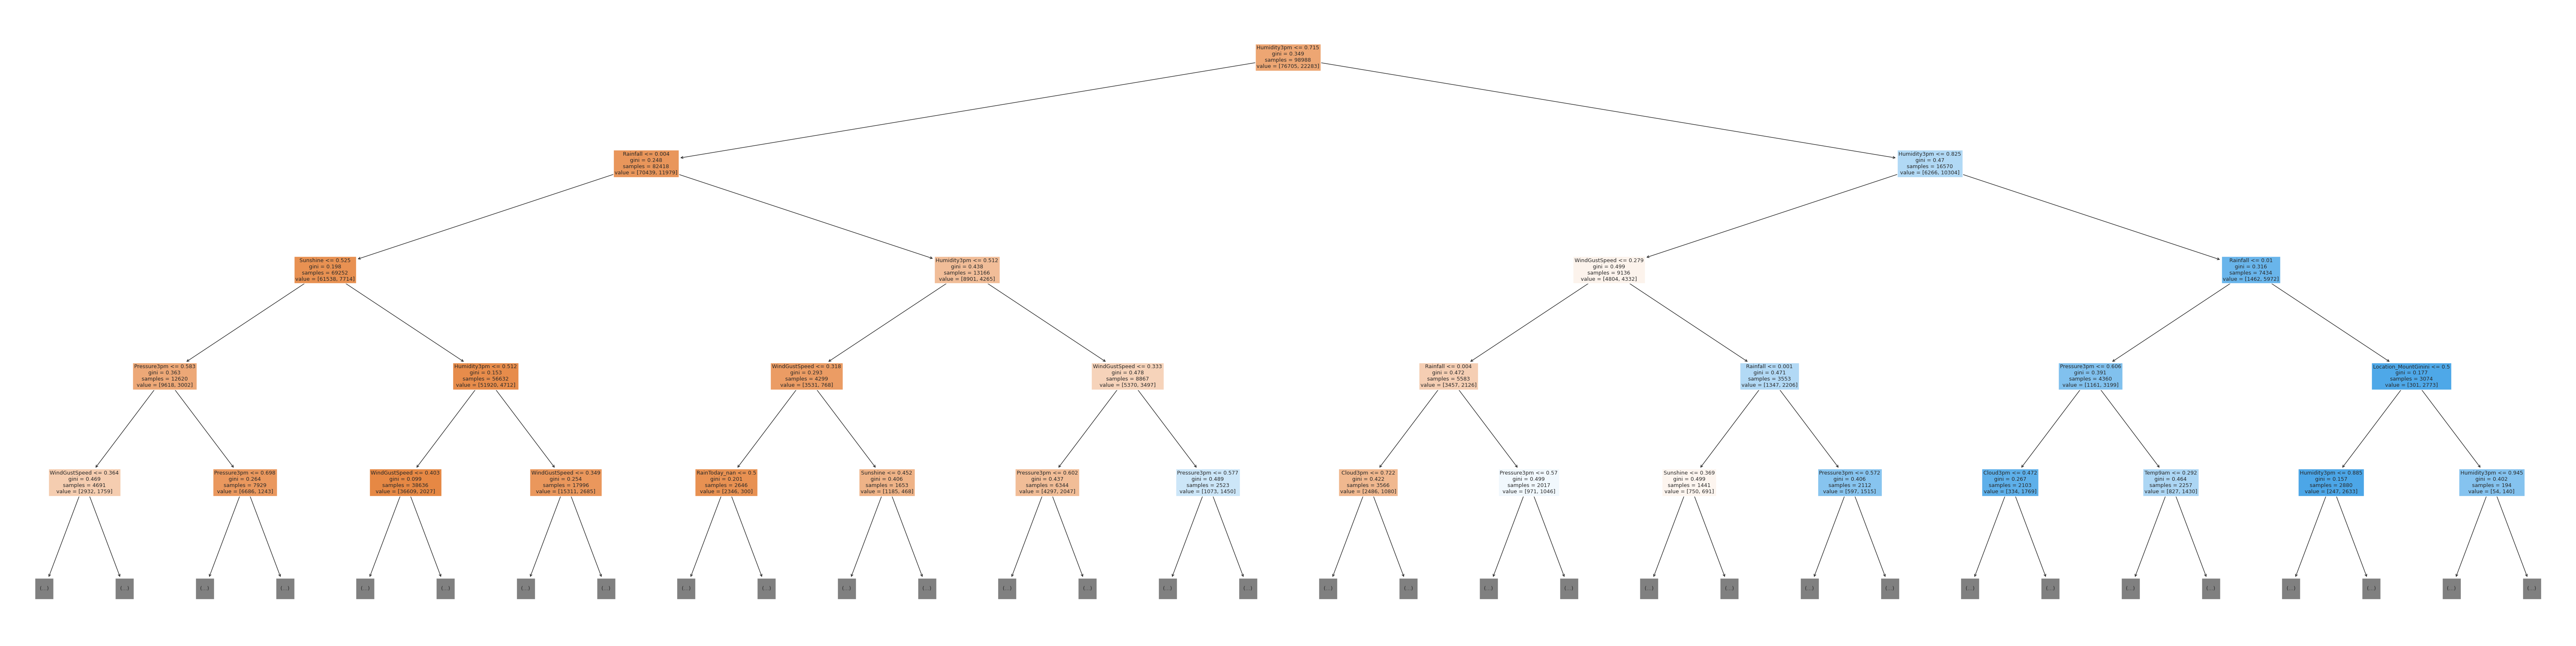

In [ ]:
from sklearn.tree import plot_tree, export_text

plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=4, filled=True);

Note the gini value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data. A lower gini index indicates a better split, a perfect split has gini index 0. It decides where to split the column. While training, the model evaluates all possible splits across all possible columns and picks the best one. Then it recursively performs optimal splits for each of the 2 portions. It is often very inefficient to check all possible splits so the model uses a heuristic (predefined strategy) combined with randomization. The decision tree grows layer by layer.

In [ ]:
model.tree_.max_depth #returns the depth of the tree

48

The tree can also be displayed as text, using export_text.

In [ ]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated

You can also return the most important features based on the gini index.

In [ ]:
model.feature_importances_

array([3.48942086e-02, 3.23605486e-02, 5.91385668e-02, 2.49619907e-02,
       4.94652143e-02, 5.63334673e-02, 2.80205998e-02, 2.98128801e-02,
       4.02182908e-02, 2.61441297e-01, 3.44145027e-02, 6.20573699e-02,
       1.36406176e-02, 1.69229866e-02, 3.50001550e-02, 3.04064076e-02,
       2.24086587e-03, 2.08018104e-03, 1.27475954e-03, 7.26936324e-04,
       1.39779517e-03, 1.15264873e-03, 6.92808159e-04, 1.80675598e-03,
       1.08370901e-03, 1.19773895e-03, 8.87119103e-04, 2.15764220e-03,
       1.67094731e-03, 7.98919493e-05, 1.10558668e-03, 1.42008656e-03,
       4.10087635e-04, 1.09028115e-03, 1.44164766e-03, 9.08284767e-04,
       1.05770304e-03, 6.18133455e-04, 1.80387272e-03, 2.10403527e-03,
       2.74413333e-04, 7.31599405e-04, 1.35408990e-03, 1.54759332e-03,
       1.30917564e-03, 1.07134670e-03, 8.36408023e-04, 1.62662229e-03,
       1.00326116e-03, 2.16053455e-03, 8.46802258e-04, 1.88919081e-03,
       9.29325203e-04, 1.29545157e-03, 1.27604831e-03, 5.12736888e-04,
      

Turn this into a dataframe to visualize.

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df.head(10)

,feature,importance
9,Humidity3pm,0.261441
11,Pressure3pm,0.062057
2,Rainfall,0.059139
5,WindGustSpeed,0.056333
4,Sunshine,0.049465
8,Humidity9am,0.040218
14,Temp9am,0.035000
0,MinTemp,0.034894
10,Pressure9am,0.034415
1,MaxTemp,0.032361


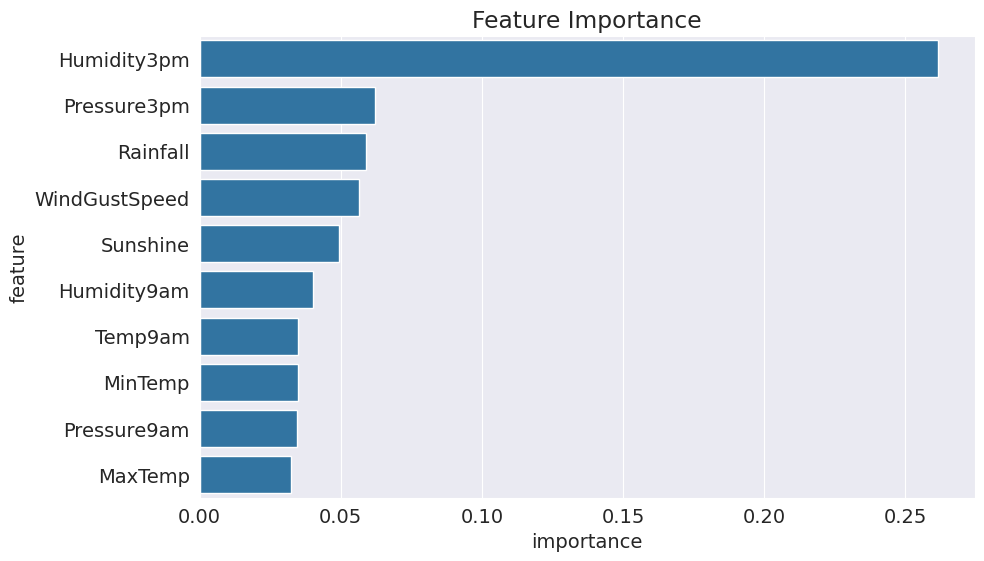

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

As can see humidity at 3pm is the most important indicator of rain as identified by the decision tree, hence why its the root node.

##Regularization and Hyperparameter Training

In [ ]:
#Check the arguments to see what hyperparameters exist for the model

?DecisionTreeClassifier

It has several criterion, gini index, entropy or log loss. The splitter can be chosen to be "best" or "random", the latter may improve regularization. max_depth controls the maximum depth of the tree. min_samples_split is the minimum number of samples required to split an internal node. min_samples_leaf are the minimum etc. There are a lot of arguments.

Focus on max_depth and max_leaf_nodes for regularization. These 2 parameters are responsible for pruning regularization (stopping the tree early). You could also do CCP (Cost complexity pruning) which creates the whole tree first and then calculates which leaf nodes should be cut as they provide little predictive power (aka weakest link pruning)


Ensemble methods like random forest or gradient boosting may reduce overfitting.

In [ ]:
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_val, val_targets), model.score(X_test, test_targets)

(0.8342930456216915, 0.8356450583251117, 0.8232463232463233)

Training accuracy has gone down but the validation accuracy has gone up so things have improved with max_depth 8.

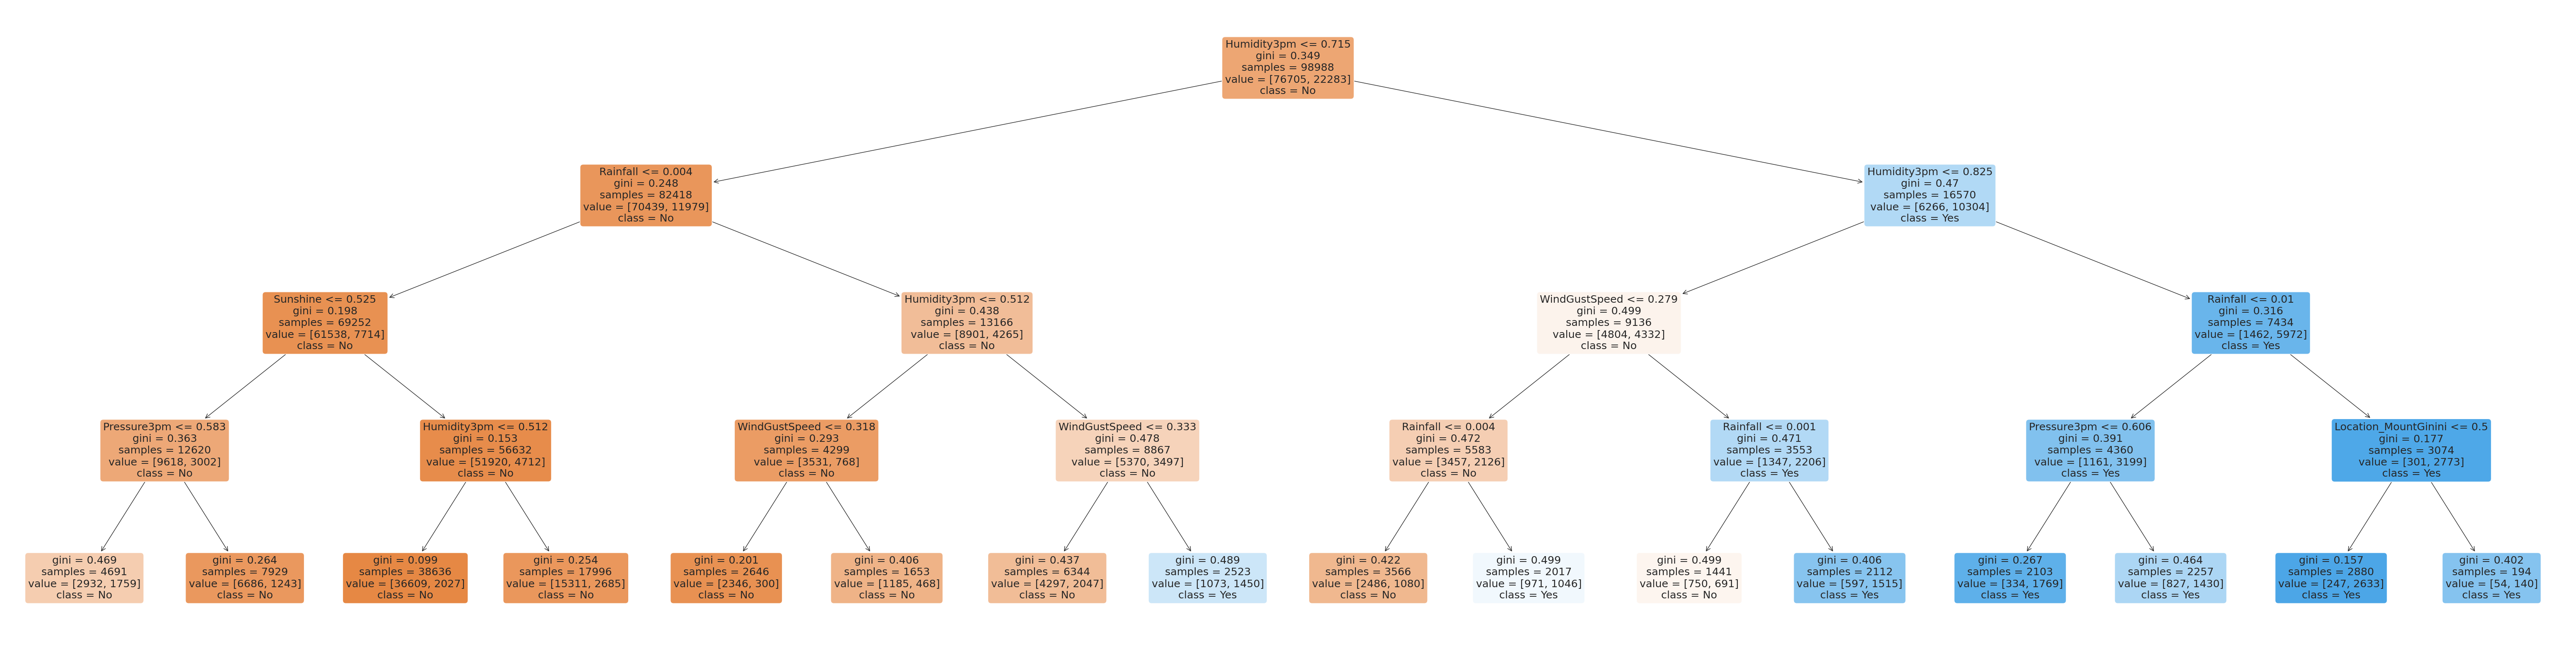

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [ ]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- class: No
|   |   |   |--- Pressure3pm >  0.58
|   |   |   |   |--- class: No
|   |   |--- Sunshine >  0.52
|   |   |   |--- Humidity3pm <= 0.51
|   |   |   |   |--- class: No
|   |   |   |--- Humidity3pm >  0.51
|   |   |   |   |--- class: No
|   |--- Rainfall >  0.00
|   |   |--- Humidity3pm <= 0.51
|   |   |   |--- WindGustSpeed <= 0.32
|   |   |   |   |--- class: No
|   |   |   |--- WindGustSpeed >  0.32
|   |   |   |   |--- class: No
|   |   |--- Humidity3pm >  0.51
|   |   |   |--- WindGustSpeed <= 0.33
|   |   |   |   |--- class: No
|   |   |   |--- WindGustSpeed >  0.33
|   |   |   |   |--- class: Yes
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- WindGustSpeed <= 0.28
|   |   |   |--- Rainfall <= 0.00
|   |   |   |   |--- class: No
|   |   |   |--- Rainfall >  0.00
|   |   |   |   |--- class: Yes
|   |   |--- WindGustSpe

Now we can do hyperparameter tuning so create a helper function that examines different depths.

In [ ]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_error = 1 - model.score(X_train, train_targets)
    val_error = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_error, 'Validation Error': val_error}

errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.158029
8,9,0.140906,0.156578
9,10,0.132945,0.157333


Now max_depth doesnt affect validation error that much it drops to around 0.154 at depth 7 but otherwise its around 0.18 ish. Plot it

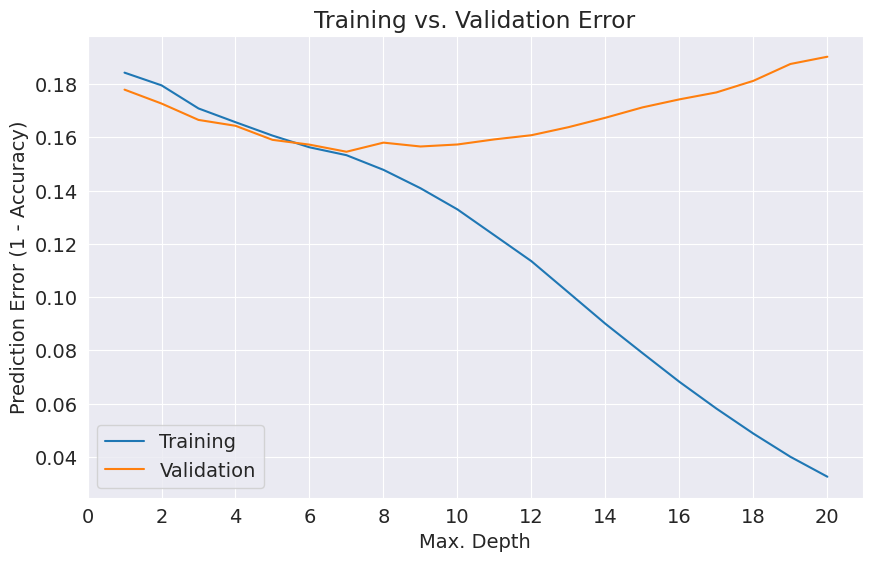

In [ ]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

In [ ]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8453949277465034

Now try doing it with max_leaf_nodes

In [ ]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)
model.fit(X_train, train_targets)
model.score(X_train, train_targets), model.score(X_val, val_targets), model.tree_.max_depth

(0.8480421869317493, 0.8442342290058615, 12)

By controlling the number of leaf nodes we were able to go deeper and achieve more accuracy while still keeping the validation approximately the same, as it kept other paths shorter. The decision tree does not go layer by layer. It figures which is the best leaf node to split and splits that one. Which is why some are shorter.

In [ ]:
model_text = export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Sunshine <= 0.05
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.05
|   |   |   |   |   |   |   |--- Pressure3pm <= 0.43
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- Pressure3pm >  0.43
|   |   |   |   |   |   |   |   |--- Humidity3pm <= 0.57
|   |   |   |   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |   |--- WindDir9am_NNE >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindD

In [ ]:
def max_leaf_error(md):
    model = DecisionTreeClassifier(max_leaf_nodes=md, random_state=42)
    model.fit(X_train, train_targets)
    train_error = 1 - model.score(X_train, train_targets)
    val_error = 1 - model.score(X_val, val_targets)
    return {'Max Leaf Nodes': md, 'Training Error': train_error, 'Validation Error': val_error}

errors_df = pd.DataFrame([max_leaf_error(md) for md in range(87, 152, 2)])
errors_df

,Max Leaf Nodes,Training Error,Validation Error
0,87,0.154362,0.155708
1,89,0.154362,0.155708
2,91,0.154362,0.155708
3,93,0.154362,0.155708
4,95,0.154190,0.155592
5,97,0.154180,0.155650
6,99,0.153998,0.155708
7,101,0.153766,0.156056
8,103,0.153493,0.155534
9,105,0.153150,0.155534


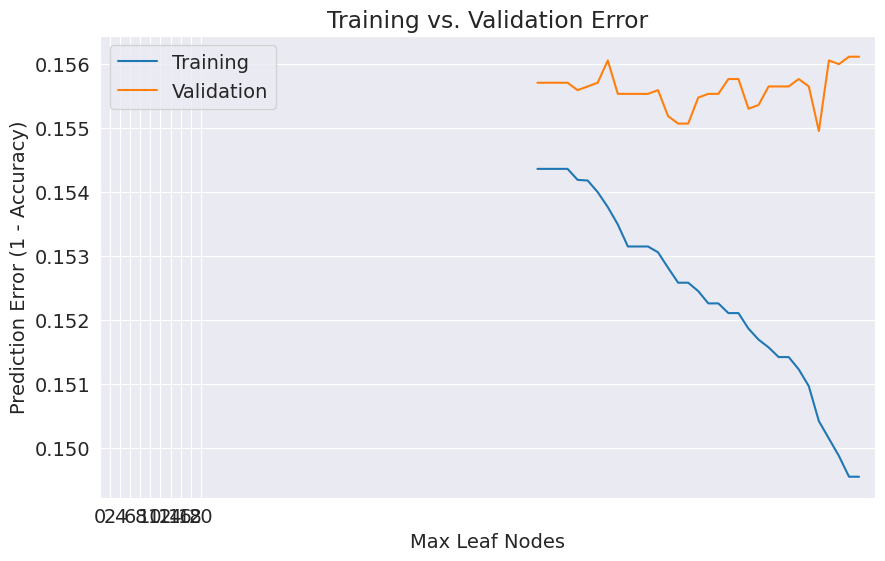

In [ ]:
plt.figure()
plt.plot(errors_df['Max Leaf Nodes'], errors_df['Training Error'])
plt.plot(errors_df['Max Leaf Nodes'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

#Random Forest

The idea is that each decision tree will be trained with slightly different parameters and they will make different kinds of errors and upon averaging most of their errors will cancel out. This idea is the wisdom of the crowd. At the end for classifiers vote.

##Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#njobs determines what cpu cores will be used
#if none, only 1 core
#if =-1 will use all cores
#n_estimators is how many estimaors 100 by default
model = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=100)
model.fit(X_train, train_targets)

print(model.score(X_train, train_targets), model.score(X_val, val_targets))

#probabiligty of class is simply fraction of trees which predicted that class

train_probs = model.predict_proba(X_train)
train_probs

0.9999494888269285 0.8566537055307295


array([[0.93, 0.07],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.96, 0.04]])

Can also access individual decision trees using model.estimators_

In [ ]:
model.estimators_[0], len(model.estimators_)

And plot each tree

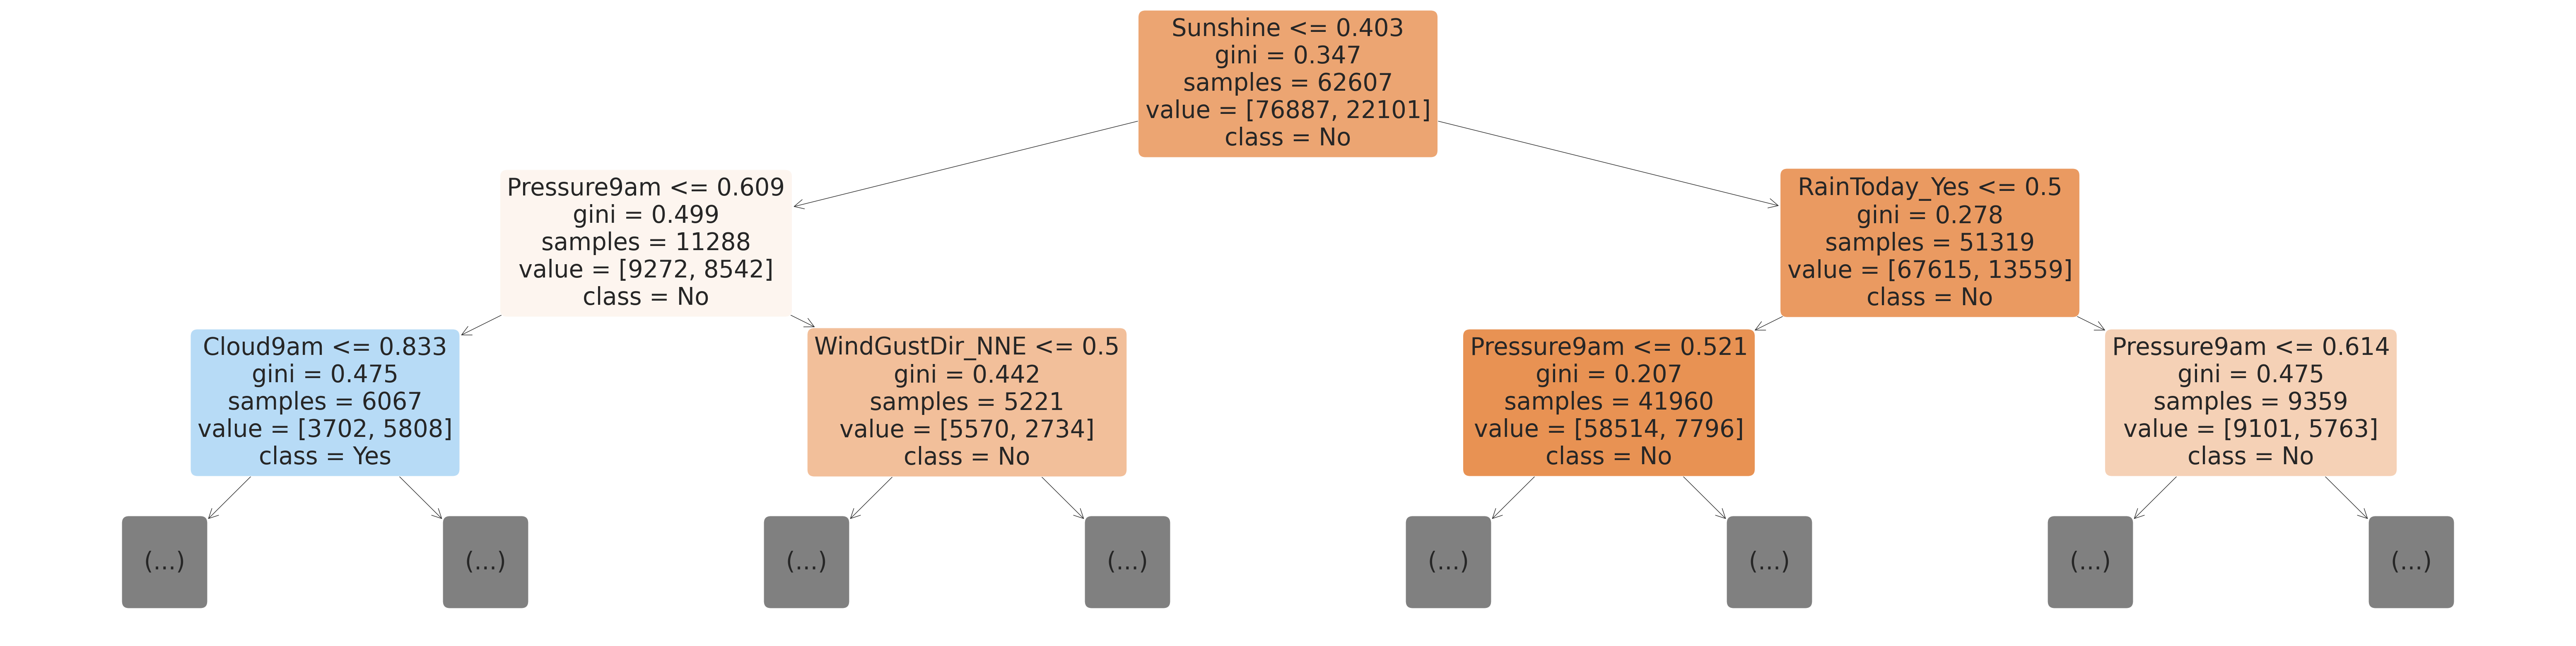

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

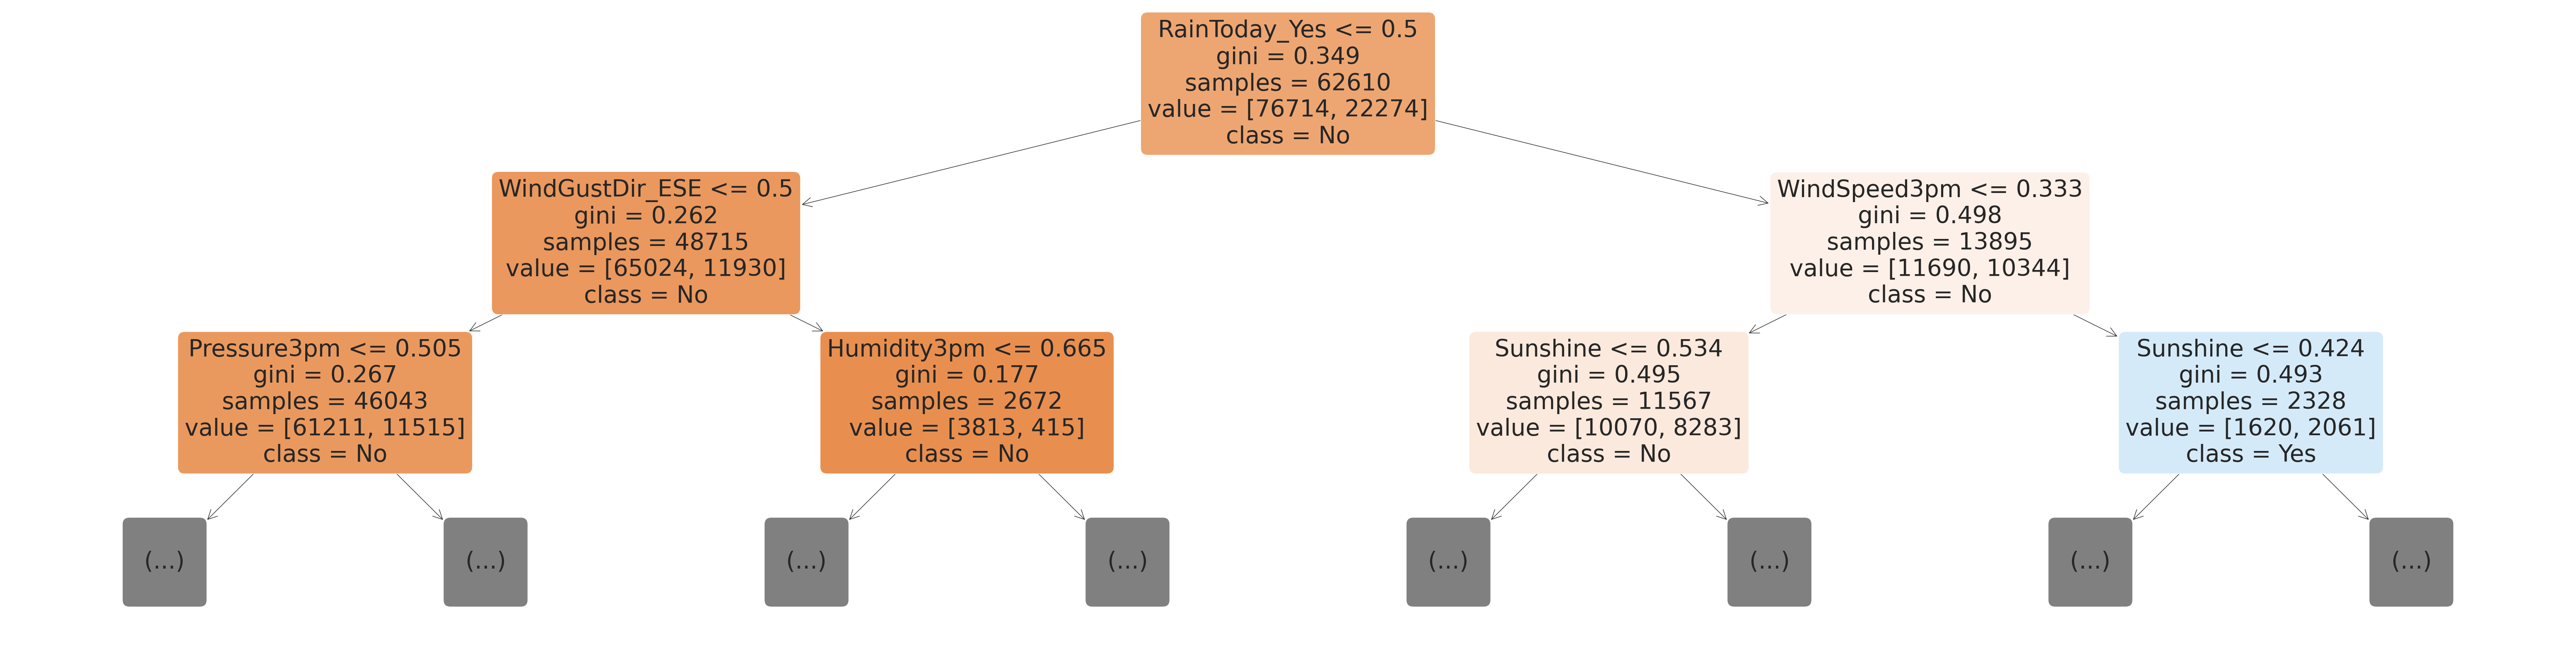

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[20], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

Just like decision trees, random forests also assign importance to each feature by combining importance from individual trees.

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df.head(10)

,feature,importance
9,Humidity3pm,0.139904
4,Sunshine,0.053696
11,Pressure3pm,0.052713
8,Humidity9am,0.050051
2,Rainfall,0.048077
10,Pressure9am,0.047944
5,WindGustSpeed,0.047477
15,Temp3pm,0.044379
1,MaxTemp,0.041865
0,MinTemp,0.041199


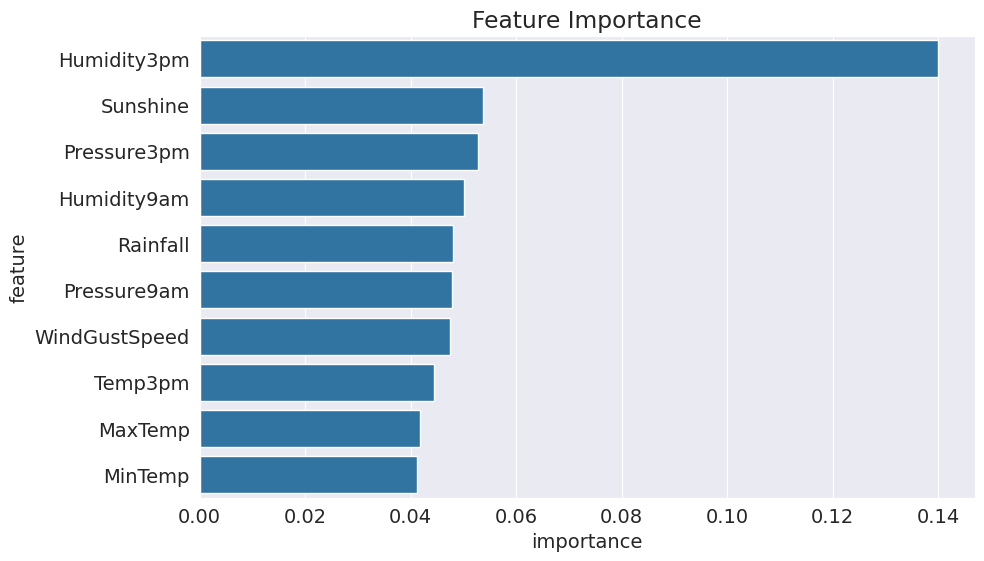

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Distribution is a lot less skewed than for a single decision tree.

##Hyperparameter Tuning

The more randomness you bring the less overfitting you have.

**n_estimators**

With more estimators you will get better validation results. But try to get as few as needed, if increasing brings marginal improvement then its not worth the extra computation. So its about balancing computation and accuracy. Doing 500 estimators increases accuracy by 0.2% which isnt worth the 5x extra computation. Increasing this wont worry about overfitting as its random

**max_depth and max_leaf_nodes**

this is passed to each decision tree.


**max_features**

Instead of picking all the features for every split, we can specify a fraction of features be chosen randomly to figure out a split. This will introduce more diversity among the decision trees.

The args it takes are 'sqrt', 'log2', int or float.

If int then consider max_features features at each split. If float its a fraction. If auto its sqrt(n_features), same as sqrt. If log2 its log2(n_features) and if none its n_features. So try several options.


**min_samples_split and min_samples_leaf**

By default the tree splits every node that has 2 or more. You can increase these values to change behavior.

In [ ]:
#Using keyword arguments so its easier to test hyperparams

def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    print(params, model.score(X_train, train_targets), model.score(X_val, val_targets))

test_params(n_estimators=100, max_depth=5)
test_params(max_leaf_nodes=2 ** 20)

{'n_estimators': 100, 'max_depth': 5} 0.8197862367155615 0.8240961058557251
{'max_leaf_nodes': 1048576} 0.9999595910615429 0.8568278103418258


In [ ]:
test_params(max_features='log2')
test_params(max_features=3)
test_params(max_features='sqrt')

{'max_features': 'log2'} 0.9999595910615429 0.8558992513493123
{'max_features': 3} 0.9999494888269285 0.8543323080494458
{'max_features': 'sqrt'} 0.9999494888269285 0.8566537055307295


In [ ]:
test_params(min_samples_split=3, min_samples_leaf=2)
test_params(min_samples_split=100, min_samples_leaf=60)

{'min_samples_split': 3, 'min_samples_leaf': 2} 0.9625005051117307 0.8565956705936975
{'min_samples_split': 100, 'min_samples_leaf': 60} 0.8495676243585081 0.8451047530613429


Lets look at a few more hyperparameters.

**bootstrap**

By default the random forest doesn't use the entire dataset for training, it uses bootstrapping. For each tree, rows from the dataset are picked one by one randomly with replacement so some rows may show up multiple times, some not at all. This helps the forest generalize better because each tree only sees a fraction of the dataset and some rows randomly get higher weightage than others.

**max_samples**

When bootstrapping is enabled, you can control the number/fraction of rows to be considered for each bootstrap using max_samples. This can help during generalization.

If none draw X.shape[0] samples, if int then draw max_samples, if float draw a fraction.


**min_impurity_decrease**

This controls the threshold for splitting nodes. A node will be split if this split induces a decrease of the imprity (Gini index in this case) greater than or equal to this value, its 0 by default and can help reduce overfitting.

In [ ]:
test_params(max_samples=0.9)

{'max_samples': 0.9} 0.9997676486038711 0.8565376356566653


In [ ]:
test_params(min_impurity_decrease=1e-7)
test_params(min_impurity_decrease=1e-2)

{'min_impurity_decrease': 1e-07} 0.9996060128500425 0.8561313910974406
{'min_impurity_decrease': 0.01} 0.774891906089627 0.7882885497069235


The last method is the class_weight parameter. In our dataset we have 77.8% nos and 22% yes so maybe we have to give rows with that class a higher weight to give equal importance, to give balancing.

In [ ]:
test_params(class_weight={'No': 1, 'Yes': 2}) #here you give more weight
test_params(class_weight='balanced') #sci kit will figure weight

{'class_weight': {'No': 1, 'Yes': 2}} 0.9999595910615429 0.8558412164122802
{'class_weight': 'balanced'} 0.9999595910615429 0.8553769369160235


##General single-input predictions

In [ ]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [ ]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

predict_input(model, new_input)

<ipython-input-42-e8d3fc4899c8>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
<ipython-input-42-e8d3fc4899c8>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
<ipython-input-42-e8d3fc4899c8>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

('Yes', 0.8)

In [ ]:
import joblib

aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

In [ ]:
aussie_rain2 = joblib.load('aussie_rain.joblib')
test_preds2 = aussie_rain2['model'].predict(X_test)
accuracy_score(test_targets, test_preds2)

0.8447678447678447